# HW08 - Instrumental Variables (due November 23rd)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [2]:
!pip install linearmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 12.6 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.3 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompa

In [34]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [4]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


### OLS

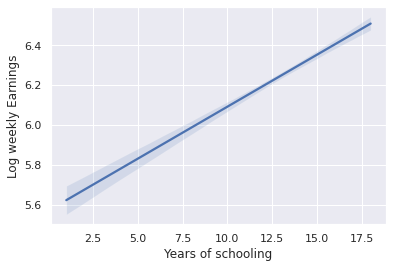

In [6]:
##plot log wages against education
sns.set_theme()
plot = sns.regplot(data=df, y='lwage', x='educ', scatter=False, ci=95)
plot.set(ylabel='Log weekly Earnings', xlabel='Years of schooling')
plt.show()

In [53]:
##Regress log wages (lwage) against education and include controls, use robust standard errors.
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

covariates = ['age', 'nearc2', 'nearc4', 'motheduc', 'fatheduc']
# df['index'] = df.index
# df = df.set_index(["index", "id"])
df = df.dropna(subset=['lwage', 'educ']+covariates)

exog = sm.add_constant(df[covariates + ['educ']])
ols = PanelOLS(df.lwage, exog, entity_effects=False).fit(cov_type='robust')
print(ols)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.2001
Estimator:                   PanelOLS   R-squared (Between):              0.2001
No. Observations:                2220   R-squared (Within):               0.0000
Date:                Mon, Nov 21 2022   R-squared (Overall):              0.2001
Time:                        20:29:37   Log-likelihood                   -1077.5
Cov. Estimator:                Robust                                           
                                        F-statistic:                      92.284
Entities:                        3006   P-value                           0.0000
Avg Obs:                       0.7385   Distribution:                  F(6,2213)
Min Obs:                       0.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             88.782
                            

**What are other possible confunders?**

For instance, mother and father education impact both the education itself and the log wages as that contributes to the overall education.

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

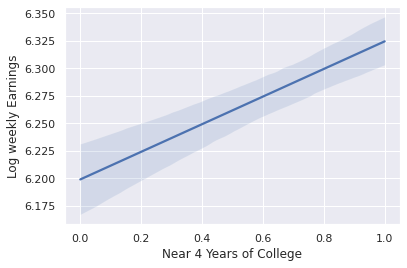

In [24]:
##plot log wages against nearc4
plot = sns.regplot(data=df, y='lwage', x='nearc4', scatter=False, ci=95)
plot.set(ylabel='Log weekly Earnings', xlabel='Near 4 Years of College')
plt.show()

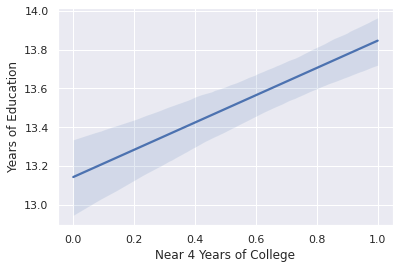

In [25]:
##plot education against nearc4
plot = sns.regplot(data=df, y='educ', x='nearc4', scatter=False, ci=95)
plot.set(ylabel='Years of Education', xlabel='Near 4 Years of College')
plt.show()

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

Positive because we see a clear positive correlation between them.

In [44]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors
exog_vars = ['nearc4']
exog = sm.add_constant(df[exog_vars])
fs = PanelOLS(df.educ, exog, entity_effects=False).fit(cov_type='robust')
print(fs)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   educ   R-squared:                        0.0158
Estimator:                   PanelOLS   R-squared (Between):              0.0158
No. Observations:                2220   R-squared (Within):               0.0000
Date:                Mon, Nov 21 2022   R-squared (Overall):              0.0158
Time:                        20:24:05   Log-likelihood                   -5242.5
Cov. Estimator:                Robust                                           
                                        F-statistic:                      35.677
Entities:                        3006   P-value                           0.0000
Avg Obs:                       0.7385   Distribution:                  F(1,2218)
Min Obs:                       0.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             34.477
                            

In [40]:
##predict education from the previous regression
df['educhat'] = fs.predict()

In [50]:
##run a regression of log wages on education and controls using robust standard errors
exog_vars = ['educhat', 'age', 'nearc2', 'motheduc', 'fatheduc']
exog = sm.add_constant(df[exog_vars])
twosls = PanelOLS(df.lwage, exog, entity_effects=False).fit(cov_type='robust')
print(twosls)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1737
Estimator:                   PanelOLS   R-squared (Between):              0.1737
No. Observations:                2220   R-squared (Within):               0.0000
Date:                Mon, Nov 21 2022   R-squared (Overall):              0.1737
Time:                        20:28:19   Log-likelihood                   -1113.7
Cov. Estimator:                Robust                                           
                                        F-statistic:                      93.068
Entities:                        3006   P-value                           0.0000
Avg Obs:                       0.7385   Distribution:                  F(5,2214)
Min Obs:                       0.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             91.230
                            

In [54]:
##compare the 2sls and ols estimates 
from linearmodels.panel import compare

print(compare({"ols": ols, "lwage": twosls}, precision='std-errors'))

              Model Comparison             
                             ols      lwage
-------------------------------------------
Dep. Variable              lwage      lwage
Estimator               PanelOLS   PanelOLS
No. Observations            2220       2220
Cov. Est.                 Robust     Robust
R-squared                 0.2001     0.1737
R-Squared (Within)        0.0000     0.0000
R-Squared (Between)       0.2001     0.1737
R-Squared (Overall)       0.2001     0.1737
F-statistic               92.284     93.068
P-value (F-stat)          0.0000     0.0000
===================== ========== ==========
const                     4.3104     2.8237
                        (0.0896)   (0.3919)
age                       0.0455     0.0337
                        (0.0028)   (0.0043)
nearc2                    0.0645     0.0785
                        (0.0174)   (0.0175)
nearc4                    0.0724           
                        (0.0182)           
motheduc                  0.0122

**What do you think the difference in the estimates is due to?**

Here, we introduce education hat which is a function of nearc4, which helps us explain two variables into one. This way, we make the model complexer but it also introduces some bias. In the end, we achieve better results with the more complex model.

### IV analysis

In [63]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 

iv_set = df[['reg661']]
exog = sm.add_constant(df[covariates])
iv2sls = IV2SLS(df.lwage, exog, df.educ, iv_set).fit(cov_type='robust')

print(iv2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                      0.0611
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0586
No. Observations:                2220   F-statistic:                    430.76
Date:                Mon, Nov 21 2022   P-value (F-stat)                0.0000
Time:                        20:44:26   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3.7650     0.5642     6.6734     0.0000      2.6592      4.8707
age            0.0412     0.0055     7.4778     0.00